<a href="https://colab.research.google.com/github/Talha-Naeem/Python-work/blob/master/MaskRCNN/MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and evaluating custom data using Mask R-CNN

This notebook shows a step-by-step guide to training and evaluating the custom image data using our modified Mask R-CNN.

## Import dependencies

In [1]:
!pip install git+https://github.com/wkentaro/labelme.git

  Cloning https://github.com/wkentaro/labelme.git to /tmp/pip-req-build-rlidd_qj
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/labelme.git /tmp/pip-req-build-rlidd_qj
  Resolved https://github.com/wkentaro/labelme.git to commit 85131db50e61673c008d53c1b060985a841c0613
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # display matplotlib-generated plots directly within the notebook
import yaml
from PIL import Image

In [44]:
# set up the root directory, e.g., ShinyAnimalCV/ShinyAnimalCV_SourceCode/
ROOT_DIR = os.path.abspath("/content/ShinyAnimalCV/ShinyAnimalCV_SourceCode")

## Import modified Mask R-CNN from `mrcnn`

The `mrcnn/` can be downloaded from https://github.com/uf-aiaos/ShinyAnimalCV/tree/main/ShinyAnimalCV_SourceCode/mrcnn

In [3]:
!git clone https://github.com/uf-aiaos/ShinyAnimalCV.git

Cloning into 'ShinyAnimalCV'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 354 (delta 127), reused 183 (delta 101), pack-reused 129 (from 1)
Receiving objects: 100% (354/354), 32.80 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [4]:
%cd ShinyAnimalCV/ShinyAnimalCV_SourceCode/mrcnn

/content/ShinyAnimalCV/ShinyAnimalCV_SourceCode/mrcnn


In [27]:
!ls

Information.R  logs  mrcnn  PretrainedML.py  pyfunc.R  server.R  ui.R


In [28]:
import sys
sys.path.append('/content/ShinyAnimalCV/ShinyAnimalCV_SourceCode/mrcnn')

In [29]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

## Set up the hyperparameters for Mask R-CNN model

In [30]:
from mrcnn.config import Config

class ShapesConfig(Config):
    """Configuration for training custom data.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name, such as pig when training pig image data
    NAME = "pig"
    # Train on 1 GPU and 1 images per GPU. Batch size is equal to 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50" # here we use resnet50 for training small dataset
    # Number of classes
    NUM_CLASSES = 1 + 1 # background + stem
    # set up steps per epoch
    STEPS_PER_EPOCH = 30
    # confidence score
    DETECTION_MIN_CONFIDENCE = 0.9
    # set up image dim
    IMAGE_MIN_DIM = 400
    # Set mini mask to false; It is TRUE in default config
    USE_MINI_MASK = False

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Define a class of `Dataset` to import data

In [39]:
class Dataset(utils.Dataset):
    # get the number of objects
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # interpret the yaml file
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.full_load(f.read())
            labels = temp['label_name']
            del labels[0]
        return labels

    def draw_mask(self, num_obj, mask, image,image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    def load_shapes(self, img_floder, mask_floder, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "pig") # replace pig with the label name that you created when labeling the data
        imglist = os.listdir(img_floder)
        for i in range(0, len(imglist)):
            filestr   = imglist[i].split(".")[0]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "/labelme_json/" + filestr + "_json/info.yaml"
            cv_img    = cv2.imread(img_floder + "/" + filestr + ".png")
            print('cv_img: ', i, img_floder + "/" + filestr + ".png")
            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                               width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info  = self.image_info[image_id]
        count = 1  # number of object
        img   = Image.open(info['mask_path'])
        num_obj   = self.get_obj_index(img)
        mask  = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask  = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("pig") != -1:
                labels_form.append("pig")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

### Set the path to the input dataset

In [40]:
# Fill the actual folder path which contains your training dataset, validation dataset, testing dataset, and cv2_mask.
dataset_root_path="/content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model"

# set the path to train, validationl, and test images
img_train_floder = dataset_root_path + "/pic_train"
img_val_floder = dataset_root_path + "/pic_val"
img_test_floder = dataset_root_path + "/pic_test"

# set the path to mask images
mask_floder = dataset_root_path + "/cv2_mask"

In [41]:
#load training dataset
print("train dataset")
dataset_train = Dataset()
dataset_train.load_shapes(img_train_floder, mask_floder, dataset_root_path)
dataset_train.prepare()

#load validation dataset
print("validation dataset")
dataset_val = Dataset()
dataset_val.load_shapes(img_val_floder, mask_floder, dataset_root_path)
dataset_val.prepare()

#load test dataset
print("test dataset")
dataset_test = Dataset()
dataset_test.load_shapes(img_test_floder, mask_floder, dataset_root_path)
dataset_test.prepare()

train dataset
cv_img:  0 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_8.png
cv_img:  1 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_2.png
cv_img:  2 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_3.png
cv_img:  3 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_6.png
cv_img:  4 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_7.png
cv_img:  5 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_10.png
cv_img:  6 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_9.png
cv_img:  7 /content/ShinyAnimalCV/ExampleData/Example_images_for_training_and_evaluating_model/pic_train/train_1.png
cv_img:  8 /content/ShinyAnimalCV/ExampleData/Exa

### Load and display a random image to check if data is loaded successfully (optional)

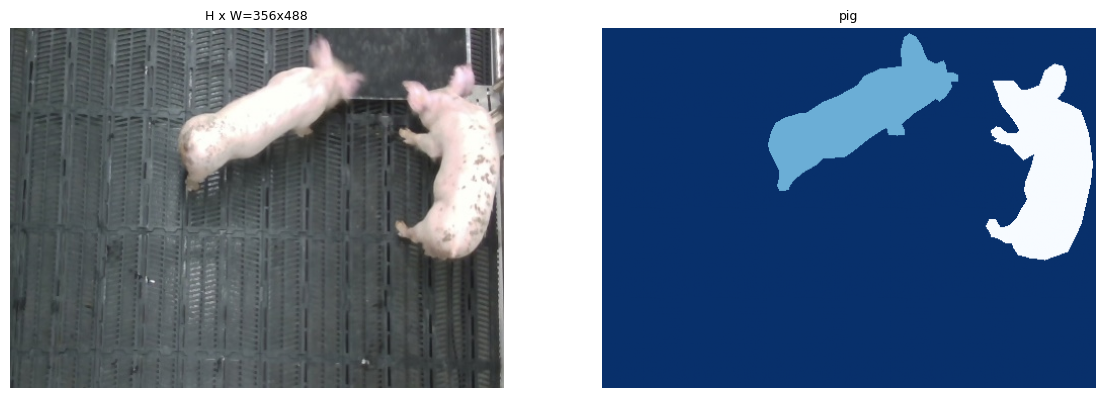

['BG', 'pig']


In [42]:
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)
    print(dataset_train.class_names)

## Build Mask R-CNN models

### Create a training model

This section shows how to create a Mask R-CNN model and specify the initial weights for training. Below are two ways to set up the initial weights:

- COCO Pretrained Weights: If you are training your model on a new dataset for the first time, it is generally recommended to initialize your model with pretrained weights from a large public dataset, such as COCO.

- Last Training Weights: If you want to continue training the model based on previous results or your training was interrupted for some reason and you want to resume your training from where you left off rather than starting over.

#### Initiate the training model

In [48]:
# directory to save logs and trained models
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# create model in training mode
model = modellib.MaskRCNN(mode ="training", config= config, model_dir = MODEL_DIR)

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, None, 4), dtype=float32, sparse=False, name=input_gt_boxes>',)
  • kwargs={'mask': 'None'}

#### Load the initial weights

In [ ]:
# specify which initial weight to start with: "coco" or "last"
init_with = "coco" # here we use "coco" as an exmaple

# local path to coco weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# download coco weights if it is not available in local
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

if init_with == "coco":
    # load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])

elif init_with == "last":
    # load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

#### Start model training

Here we trained the model following three stages:
1. Only train the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine tune `4+` layers. Pass `layers='4+'` to the `train()` function.

3. Fine tune all layers. Pass `layers="all` to train all layers.

In [ ]:
%load_ext tensorboard # this will print out the log of model training

# Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads'
            )

# Stage 2
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=15,
            layers='4+'
            )

# Stage 3
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers='all'
            )

print("finished training")

### Create an inference model and load trained weights obtained from previous step

In [ ]:
# set configurations for the inference model
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Create a model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Here you need to provide your actual path for your trained weights
model_path = "/Users/xiaolanbao/Dropbox (Personal)/UF/Projects/ShinyAnimalCV/Mask_RCNN/MaskRCNN_OnePig_RGB/logs/pig_heatmap/mask_rcnn_pig_heatmap_0060.h5"

# Load trained weights to the inference model
print("Loading weights from ", model_path)
tf.keras.Model.load_weights(model.keras_model, model_path, by_name=True)

In [ ]:
# Test the trained model using a random image
image_id = 3
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config,
                           image_id)

# apply the trained model to the image
results = model.detect([original_image], verbose=1)
r       = results[0]

# visualize the results
## get the information of minimum rotated bounding box using `morphologicalfeatures` function
outputs = visualize.morphologicalfeatures(r['masks'], r['class_ids'], dataset_test.class_names)
mf = outputs['morpholdf']
minbox  = outputs['minbox'] # coordinate of minbox
rangle  = outputs['rangle'] # angle of minbox

## display the detected and segmented results
visualize.display_instances_md(original_image, minbox, rangle, r['masks'], r['class_ids'],
                            dataset_test.class_names, r['scores'], ax=get_ax())

mf

### Evaluate the model performance using average precision
The average precision (AP) is calculated by averaging the precision over all recall values from 0 to 1.

In [ ]:
# Function to calculate mAP for all testing images' AP
def evaluate_model(dataset, model, cfg, iou_threshold = 0.5):
    APs = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id)
        results = model.detect([image], verbose = 1)
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                             iou_threshold = iou_threshold)
        APs.append(AP)
    mAP = np.mean(APs)
    return mAP

In [ ]:
# Calculate mAP for dataset_test by using trained model and inference configuration.
mAP = evaluate_model(dataset_test, model, inference_config)
print(f"mAP: {mAP}")